# Final Project Submission
---

## Info

* Student name: **Barto Molina**
* Student pace: **part time**
* Scheduled project review date/time: **09/10/2019 5:00 PM (EST)**
* Instructor name: **Victor Geislinger**
* Blog post URL: **TODO**

## The Project

Given the data included in the Northwind database, we'll perform a statistical analysis in order to perform hypothesis tests to answer the questions below.

**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?**  
**2. Does the customer region have a statistically significant effect on the total price of an order?**  
**3. Does the employee have a statistically significant effect on the total price of an order?**

But first, we're going to explore the database in order to understand the relationship between the different tables and the meaning of the different columns.

## Imports

We'll import the required libraries that will be used throughout the rest of the project:

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [3]:
# connection to the database
conn = sqlite3.connect("Northwind_small.sqlite")

## 0. Exploring the Dataset
---

This is the Northwind database diagram:

![Northwind DB Schema](Northwind_ERD_updated.png "Northwind DB Schema")

In order to have a better understanding of the data stored in the database, we're going to summarize the relationship between the different tables and run some queries to fetch some data related to products and orders that may be useful going forward:

We can summarize the relationship between the tables in our database as follows:

- The company has **77 products** provided by **29 suppliers** from all over the world.
- Each product falls into one of these **8 categories**: Beverages, Condiments, Confections, Dairy Products, Grains/Cereals, Meat/Poultry, Produce and Seafood.
- There are a total of **830 orders** recorded containing 2,155 different products, with 51,317 total units sold. Orders are shipped by **3 different shipping companies**.
- There are **9 employees** covering **53 territories** in **4 regions** (Eastern, Western, Northern, Southern) of the US.
- There are **91 customers** from all over the world.

We've done an initial exploration of different Orders / Products, like order no. 10254, which has different products and discounts associated:

In [4]:
pd.read_sql_query("""SELECT * FROM OrderDetail JOIN Product
                       WHERE OrderDetail.ProductID = Product.ID AND OrderID = 10254""", conn)

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,10254/24,10254,24,3.6,15,0.15,24,Guaraná Fantástica,10,1,12 - 355 ml cans,4.5,20,0,0,1
1,10254/55,10254,55,19.2,21,0.15,55,Pâté chinois,25,6,24 boxes x 2 pies,24.0,115,0,20,0
2,10254/74,10254,74,8.0,21,0.00,74,Longlife Tofu,4,7,5 kg pkg.,10.0,4,20,5,0


In [5]:
pd.read_sql_query("SELECT * FROM [Order] WHERE ID = 10254", conn)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10254,CHOPS,5,2012-07-11,2012-08-08,2012-07-23,2,22.98,Chop-suey Chinese,Hauptstr. 31,Bern,Western Europe,3012,Switzerland


After an initial exploration of all the tables, We've determined that:

- The discount is applied at the order - product level.
- The **UnitPrice** present in the OrderDetail column corresponds to the **UnitPrice** from the **Product** table when the order takes place. This price doesn't take into account the discount.

## 1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
---

First, we're going to define our hypthesis:

- **$H_{0}$ - Null Hypothesis:** Discount has no statistically significant effect on the quantity of a product in an order
- **$H_{1}$ - Alternative hypothesis:** Discount has a statistically significant effect on the quantity of a product in an order

We're going to consider a standard $\alpha$ of 0.05

Let's load the information from the order details into a dataframe in order to find the total number of items sold at a discounted price, and the discount applied:

In [6]:
df_discounts = pd.read_sql_query("""SELECT CAST (Discount * 100 AS INT) AS Discount, SUM(Quantity) AS Quantity
                       FROM OrderDetail GROUP BY Discount""", conn)

df_discounts

,Discount,Quantity
0,0,28599
1,1,2
2,2,4
3,3,5
4,4,1
5,5,5182
6,6,2
7,10,4366
8,15,4456
9,20,4351


We can see that the main discount categories are **0%**, **5%**, **10%**, **15%**, **20%** and **25%**. We'll ignore the rest of the discount categories, as there are very few items at those discount levels:

In [7]:
df_prod_disc_qty = pd.read_sql_query("""SELECT ProductName, CAST (Discount * 100 AS INT) AS Discount, Quantity AS Quantity
                       FROM OrderDetail JOIN Product ON OrderDetail.ProductID = Product.ID
                       GROUP BY OrderID, ProductId
                       HAVING Discount IN (0, 0.05, 0.10, 0.15, 0.20, 0.25)""", conn)

df_prod_disc_qty.head(15)

,ProductName,Discount,Quantity
0,Queso Cabrales,0,12
1,Singaporean Hokkien Fried Mee,0,10
2,Mozzarella di Giovanni,0,5
3,Tofu,0,9
4,Manjimup Dried Apples,0,40
5,Jack's New England Clam Chowder,0,10
6,Manjimup Dried Apples,15,35
7,Louisiana Fiery Hot Pepper Sauce,15,15
8,Gustaf's Knäckebröd,5,6
9,Ravioli Angelo,5,15


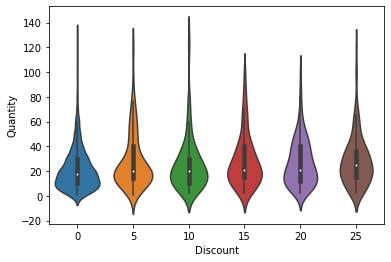

In [8]:
sns.violinplot(x=df_prod_disc_qty['Discount'],y=df_prod_disc_qty['Quantity'])
plt.show()

### Welch's T-test

First, we're going to compare the quantity of the products sold at no discount with the rest with a Welch's T-test:

In [9]:
df_nodiscount = df_prod_disc_qty[df_prod_disc_qty['Discount'] == 0].Quantity
df_discount = df_prod_disc_qty[df_prod_disc_qty['Discount'] != 0].Quantity

welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
welchs.pvalue / 2

5.0256277704215826e-11

The result is a very small p-value, much smaller than our $\alpha$ value of 0.05, meaning that the Null Hypothesis can be rejected (we can reject the hypothesis that the discount has no statistically significant effect on the quantity of a product in an order). However, we still need to calculate the effect size. In order to do that, we'll calculate the Cohen's d:

### Effect size / Cohen's d

In [10]:
# aux. function to calculate Cohen's d

def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [11]:
Cohen_d(df_discount, df_nodiscount)

0.2997078720940889

As the effect (**0.3**) is higher than **0.2** we can consider it has a reasonably positive effect

### Compare different discounts levels

In [12]:
for discount in (5, 10, 15, 20, 25):
    df_nodiscount = df_prod_disc_qty[df_prod_disc_qty['Discount'] == 0].Quantity
    df_discount = df_prod_disc_qty[df_prod_disc_qty['Discount'] == discount].Quantity

    welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
    cohens = Cohen_d(df_discount, df_nodiscount)
    print(f"Welch's T p-value for {discount}% discount = {welchs.pvalue} / Cohen's d for {discount}% discount = {cohens}")

Welch's T p-value for 5% discount = 0.00027233494432847593 / Cohen's d for 5% discount = 0.3468767736284547
Welch's T p-value for 10% discount = 0.0374559661063408 / Cohen's d for 10% discount = 0.19594203057834103
Welch's T p-value for 15% discount = 0.00017220729443627393 / Cohen's d for 15% discount = 0.3724041317472811
Welch's T p-value for 20% discount = 0.0008110033254043408 / Cohen's d for 20% discount = 0.3007122542913555
Welch's T p-value for 25% discount = 0.00015923050922125637 / Cohen's d for 25% discount = 0.3665925565267444


**We can see that the 15% discount has the highest effect on the quantity ordered with a Cohen's d of 0.37**

## 2. Does the customer region have a statistically significant effect on the total price of an order?
---

First, we're going to define our hypthesis:

- **$H_{0}$ - Null Hypothesis:** The customer region has no statistically significant effect on the total price of an order
- **$H_{1}$ - Alternative hypothesis:** The customer region has a statistically significant effect on the total price of an order

We're going to consider a standard $\alpha$ of 0.05

At the same time, we're going to analyze the cost of the freight by region as this may be related / affect the number of items ordered.

Let's find the different customer regions:

In [13]:
pd.read_sql_query("SELECT DISTINCT (region) FROM Customer", conn)

,Region
0,Western Europe
1,Central America
2,British Isles
3,Northern Europe
4,Southern Europe
5,North America
6,South America
7,Scandinavia
8,Eastern Europe


Let's calculate the total price of an order (taking into account the discount level for each product) and fetch the information related to the region and the shipping:

In [14]:
df_regions = pd.read_sql_query("""SELECT Region, OrderID, SUM(Quantity) AS Items, Freight/SUM(Quantity) AS 'Freight / Item', SUM(Quantity * UnitPrice * (1 - Discount)) AS Total, Shipper.CompanyName AS 'Shipping Co', Freight
                                   FROM OrderDetail
                                   JOIN [Order] ON OrderDetail.OrderID = [Order].ID
                                   JOIN Customer ON [Order].CustomerID = Customer.ID
                                   JOIN Shipper ON [Order].ShipVia = Shipper.ID
                                   GROUP BY OrderID""", conn)

df_regions.head(20)

,Region,OrderId,Items,Freight / Item,Total,Shipping Co,Freight
0,Western Europe,10248,27,1.199259,440.000,Federal Shipping,32.38
1,Western Europe,10249,49,0.236939,1863.400,Speedy Express,11.61
2,South America,10250,60,1.097167,1552.600,United Package,65.83
3,Western Europe,10251,41,1.008293,654.060,Speedy Express,41.34
4,Western Europe,10252,105,0.488571,3597.900,United Package,51.30
5,South America,10253,102,0.570294,1444.800,United Package,58.17
6,Western Europe,10254,57,0.403158,556.620,United Package,22.98
7,Western Europe,10255,110,1.348455,2490.500,Federal Shipping,148.33
8,South America,10256,27,0.517407,517.800,United Package,13.97
9,South America,10257,46,1.780652,1119.900,Federal Shipping,81.91


Shipping Co,Federal Shipping,Speedy Express,United Package
Region,,,
British Isles,28,15,32
Central America,12,2,7
Eastern Europe,4,1,2
North America,56,35,61
Northern Europe,15,20,20
Scandinavia,10,9,9
South America,34,44,49
Southern Europe,18,25,21
Western Europe,75,85,112


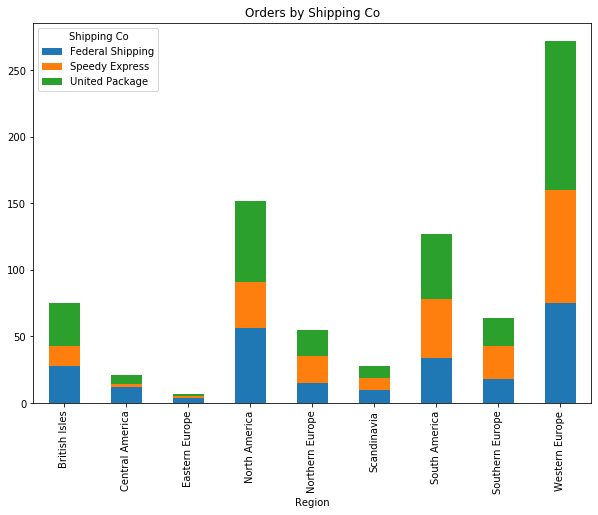

In [15]:
# we're going to create a pivot table in order to get some insights on the usage of the different shipping companies per region
df_regions_pivot = df_regions.pivot_table(index='Region', columns='Shipping Co', values='Total', aggfunc='count')
display(df_regions_pivot)
# we'll look at the usage of the different shipping companies across the different regions
df_regions_pivot.plot.bar(stacked=True, figsize=(10,7), title='Orders by Shipping Co');

We can see that the different Shipping companies are used evenly across the different regions, so we shouldn't expect any difference in the Freight for using the different shipping companies. Now, we're going to calculate the average cost of the freight per item (also checking in case there's any difference between the different shipping companies):

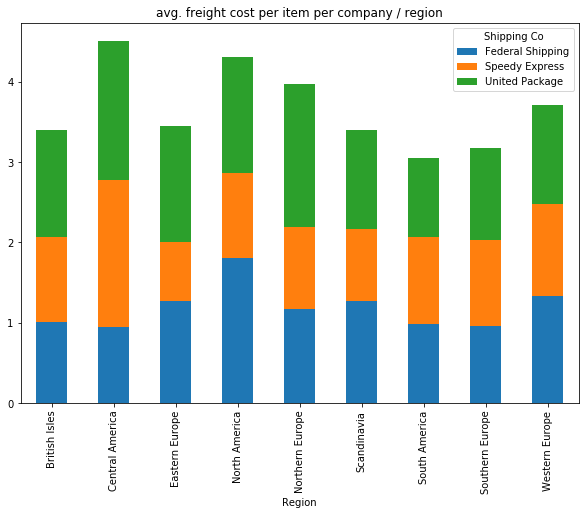

In [16]:
df_regions_freight_company = df_regions.pivot_table(index='Region', columns='Shipping Co', values='Freight / Item', aggfunc='mean')
df_regions_freight_company
df_regions_freight_company.plot.bar(stacked=True, figsize=(10,7), title='avg. freight cost per item per company / region');

Before checking our main hypothesis, let's verify first if the region has any impact on the cost of the freight:

In [17]:
df_region_NA = df_regions[df_regions['Region'] == 'North America']['Freight / Item']
df_region_others = df_regions[df_regions['Region'] != 'North America']['Freight / Item']

welchs = stats.ttest_ind(df_region_NA, df_region_others, equal_var=False)
welchs.pvalue

0.056539259955179715

as the **p-value** (0.056) is higher than our $\alpha$ value (0.05) we can't reject the null hypothesis that the region doesn't have any impact on the cost of the freight.

Now, let's have a look at the average cost of the orders per region and we'll proceed to verify if there's a significant effect between them:

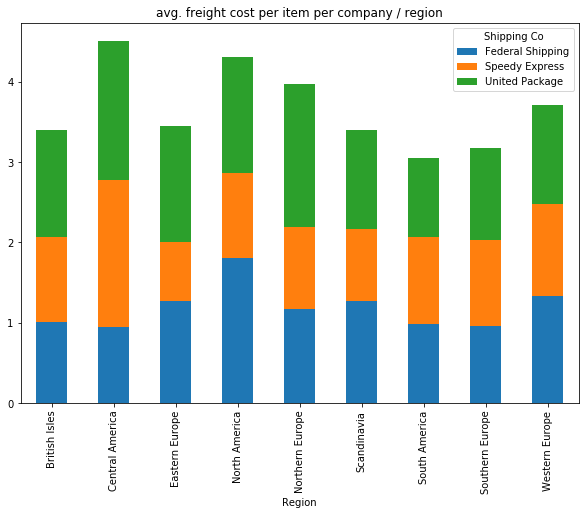

In [18]:
df_regions_freight_company = df_regions.pivot_table(index='Region', columns='Shipping Co', values='Freight / Item', aggfunc='mean')
df_regions_freight_company
df_regions_freight_company.plot.bar(stacked=True, figsize=(10,7), title='avg. freight cost per item per company / region');

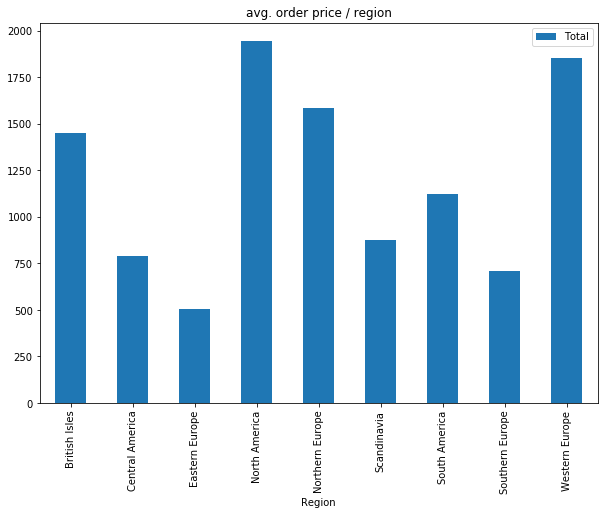

In [19]:
df_regions_avg_order = df_regions.pivot_table(index='Region', values='Total', aggfunc='mean')
df_regions_avg_order
df_regions_avg_order.plot.bar(figsize=(10,7), title='avg. order price / region');

### ANOVA

In this case, we're going to use an **ANOVA** test to compare the effect of the multiple regions on the total price of the order:

In [22]:
formula = 'Total ~ C(Region)'
lm = ols(formula, df_regions).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq     df         F        PR(>F)
C(Region)  1.502147e+08    8.0  5.739638  4.009445e-07
Residual   2.590974e+09  792.0       NaN           NaN


The result is a very small **p-value**, much smaller than our $\alpha$ value of 0.05, meaning that the Null Hypothesis can be rejected (we can reject the hypothesis that the customer region has no statistically significant effect on the total price of an order).

## 3. Does the employee have a statistically significant effect on the total price of an order?
---

First, we're going to define our hypthesis:

- **$H_{0}$ - Null Hypothesis:** The employee doesn't have a statistically significant effect on the total price of an order
- **$H_{1}$ - Alternative hypothesis:** The employee has a statistically significant effect on the total price of an order

We're going to consider a standard $\alpha$ of 0.05

In [25]:
pd.read_sql_query("SELECT DISTINCT ID, LastName, Firstname FROM Employee", conn)

,Id,LastName,FirstName
0,1,Davolio,Nancy
1,2,Fuller,Andrew
2,3,Leverling,Janet
3,4,Peacock,Margaret
4,5,Buchanan,Steven
5,6,Suyama,Michael
6,7,King,Robert
7,8,Callahan,Laura
8,9,Dodsworth,Anne


### Welch's T-test

First, we're going to compare the quantity of the products sold at no discount with the rest with a Welch's T-test:

In [ ]:
df_nodiscount = df_prod_disc_qty[df_orders['Discount'] == 0].Quantity
df_discount = df_prod_disc_qty[df_orders['Discount'] != 0].Quantity

welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
welchs.pvalue / 2

The result is a very small p-value, much smaller than our $\alpha$ value of 0.05, meaning that the Null Hypothesis can be rejected (we can reject the hypothesis that the discount has no statistically significant effect on the quantity of a product in an order). However, we still need to calculate the effect size. In order to do that, we'll calculate the Cohen's d:

### Effect size / Cohen's d

In [ ]:
Cohen_d(df_discount, df_nodiscount)

As the effect (**0.3**) is higher than **0.2** we can consider it has a reasonably positive effect

### Compare different discounts levels

In [ ]:
for discount in (5, 10, 15, 20, 25):
    df_nodiscount = df_prod_disc_qty[df_orders['Discount'] == 0].Quantity
    df_discount = df_prod_disc_qty[df_orders['Discount'] == discount].Quantity

    welchs = stats.ttest_ind(df_nodiscount, df_discount, equal_var=False)
    cohens = Cohen_d(df_discount, df_nodiscount)
    print(f"Welch's T p-value for {discount}% discount = {welchs.pvalue} / Cohen's d for {discount}% discount = {cohens}")

**We can see that the 15% discount has the highest effect on the quantity ordered with a Cohen's d of 0.37**